In [122]:
# Importing Libraries
import numpy as np   # For calculations
import pandas as pd  # For reading datasets
import matplotlib.pyplot as plt
import seaborn as sns  # For visualizations

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler   # For class balancing
from imblearn.pipeline import Pipeline
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report

from xgboost import XGBClassifier  # XGBoost model

%matplotlib inline


In [123]:
cvs_data = pd.read_csv('data_cardiovascular_risk.csv', index_col = "id" )

In [124]:
cvs_data.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [125]:
cvs_data.shape

(3390, 16)

In [126]:
cvs_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 450.2+ KB


In [127]:
# Looking up for the detailed description of dataset that is used in this project.
cvs_data.describe()

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3303.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,49.542183,1.970936,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,8.592878,1.019081,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


In [128]:
cvs_data.isnull().sum()

,0
age,0
education,87
sex,0
is_smoking,0
cigsPerDay,22
BPMeds,44
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,38


In [129]:
cvs_data.dropna(inplace=True)

After treating the missing values we now check the outliers

<Axes: >

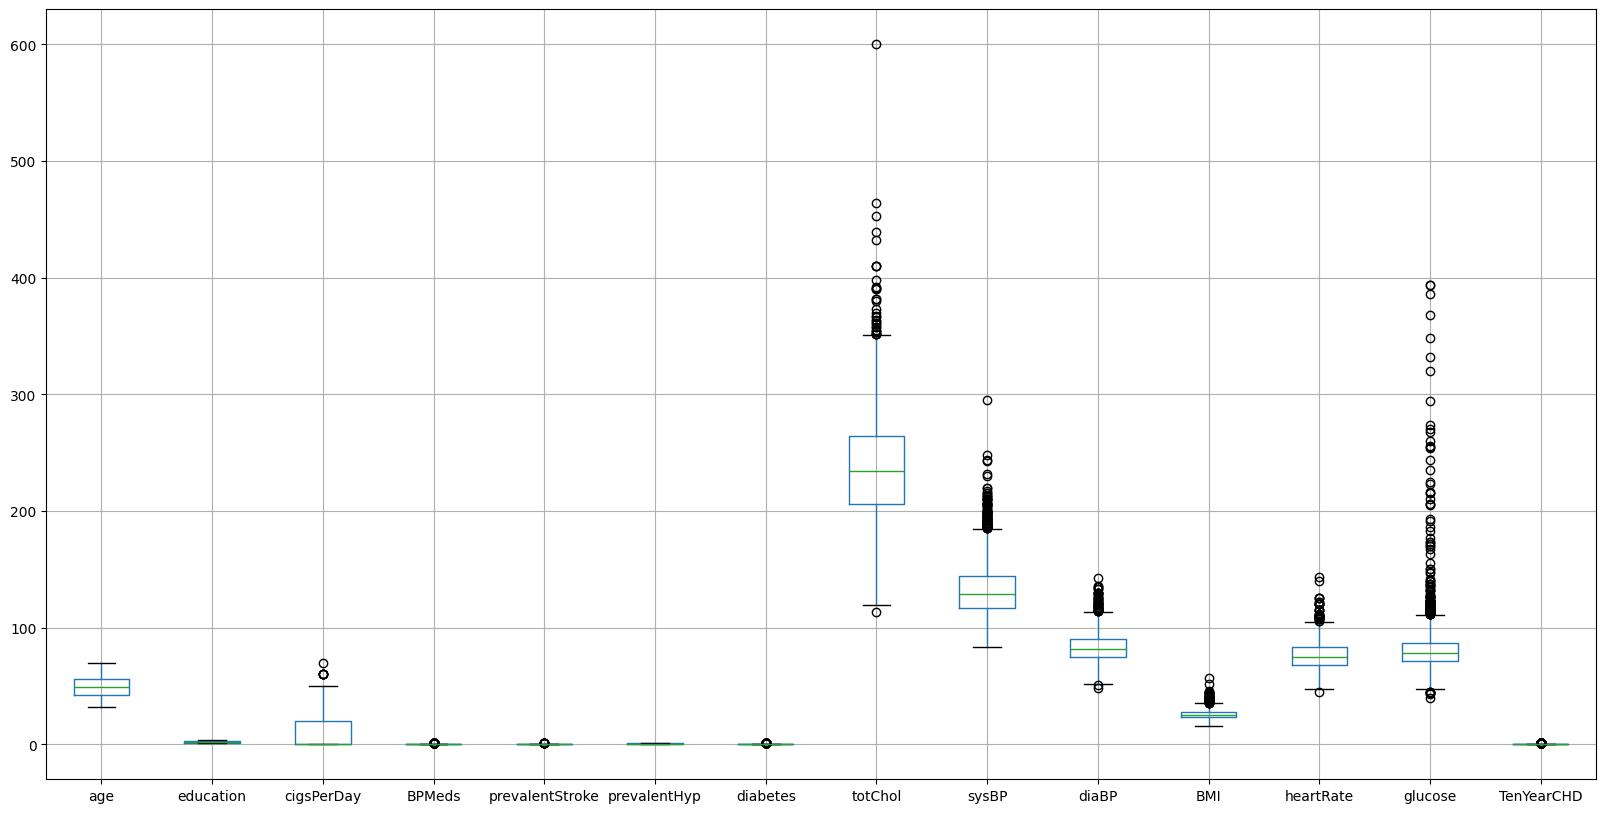

In [130]:
# Checking outlier
plt.figure(figsize=(20,10))
cvs_data.boxplot()

"Outliers are data points that deviate significantly from the typical data distribution and are considered unusual or unexpected."

Now let's check the co-relation between each feature

In [131]:
non_numeric_cols = cvs_data.select_dtypes(include=['object']).columns
for column in non_numeric_cols:
  print(f"Unique values in {column}: {cvs_data[column].unique()}")

Unique values in sex: ['M' 'F']
Unique values in is_smoking: ['NO' 'YES']


In [132]:
numerical_data = cvs_data.select_dtypes(include=[np.number])

Correlation refers to the statistical relationship between two or more variables, indicating how much they change together.

Heatmap is a graphical representation of data where values are depicted using color, typically in a grid or matrix format.

Heatmaps are used to display correlation matrices or feature importance matrices. In a correlation heatmap, each cell's color represents the strength of the correlation between two variables.

<Axes: >

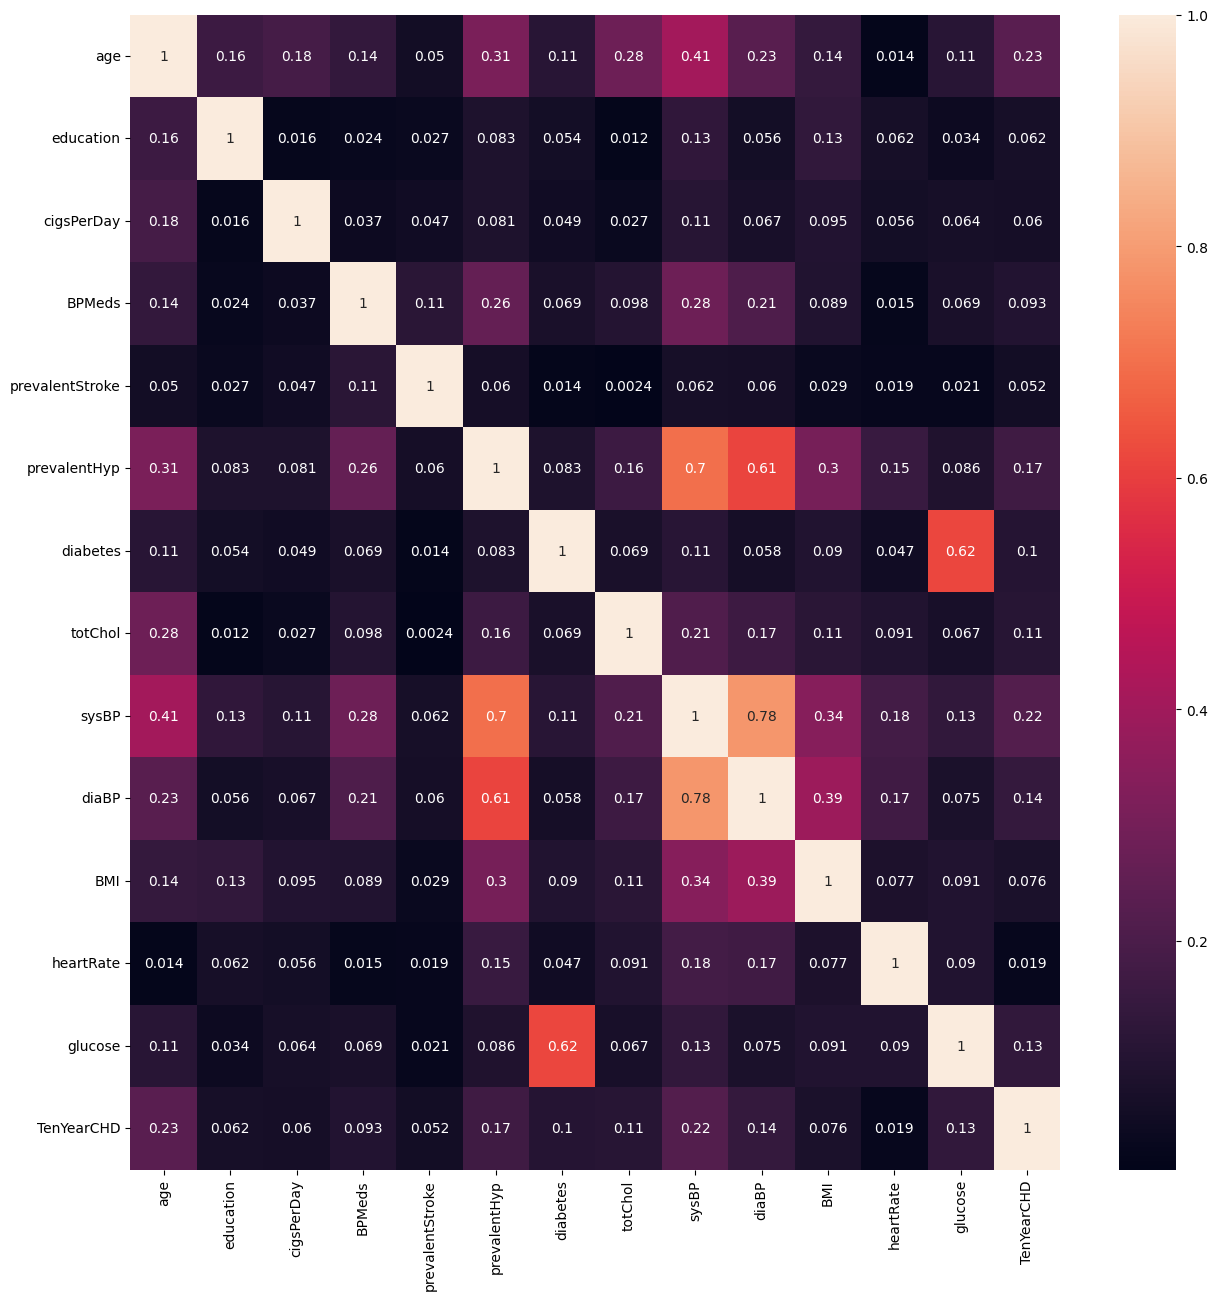

In [133]:
# Plotting the correlation matrix using heatmap
plt.figure(figsize=(15,15))
correlation = numerical_data.corr()
sns.heatmap(abs(correlation), annot=True)

There is no significant correlation between independent and dependent variables but there is a high correlation within independent variables

Which gender is prone to coronary heart disease?

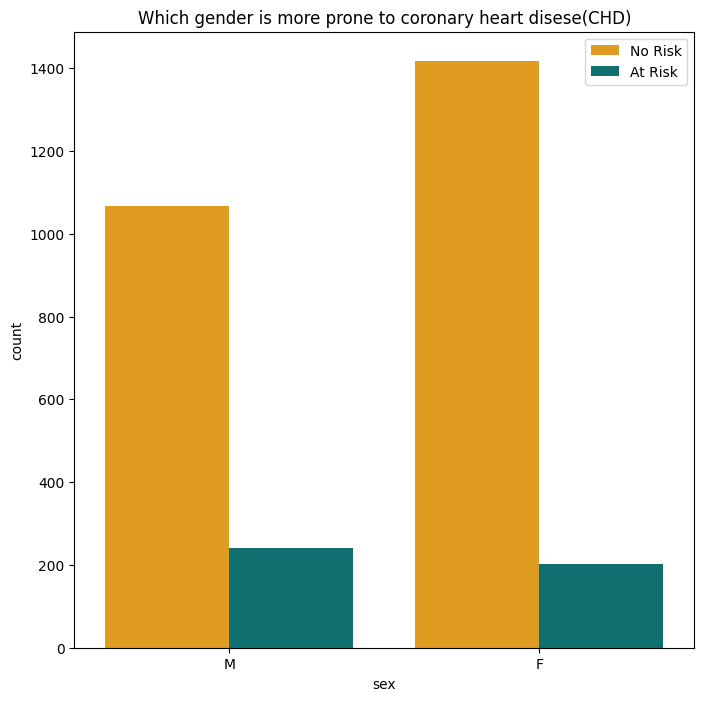

In [134]:
my_palette = {0 : 'orange', 1 : 'teal'}
plt.figure(figsize=(8,8))
sns.countplot(x = cvs_data['sex'],hue = cvs_data['TenYearCHD'], palette = my_palette)
plt.title("Which gender is more prone to coronary heart disese(CHD)")
plt.legend(['No Risk','At Risk'])
plt.show()

Are diabetic patients at more risk of coronary heart disease?

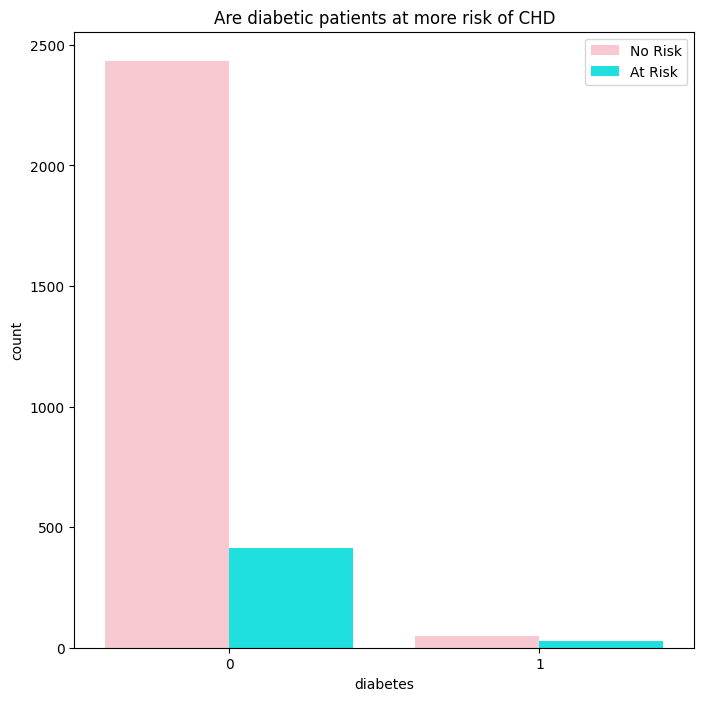

In [135]:
my_palette = {0 : 'pink', 1 : 'aqua'}
plt.figure(figsize=(8,8))
sns.countplot(x = cvs_data['diabetes'],hue = cvs_data['TenYearCHD'], palette = my_palette)
plt.title("Are diabetic patients at more risk of CHD")
plt.legend(['No Risk','At Risk'])
plt.show()

Are smokers at more risk of coronary heart disease?

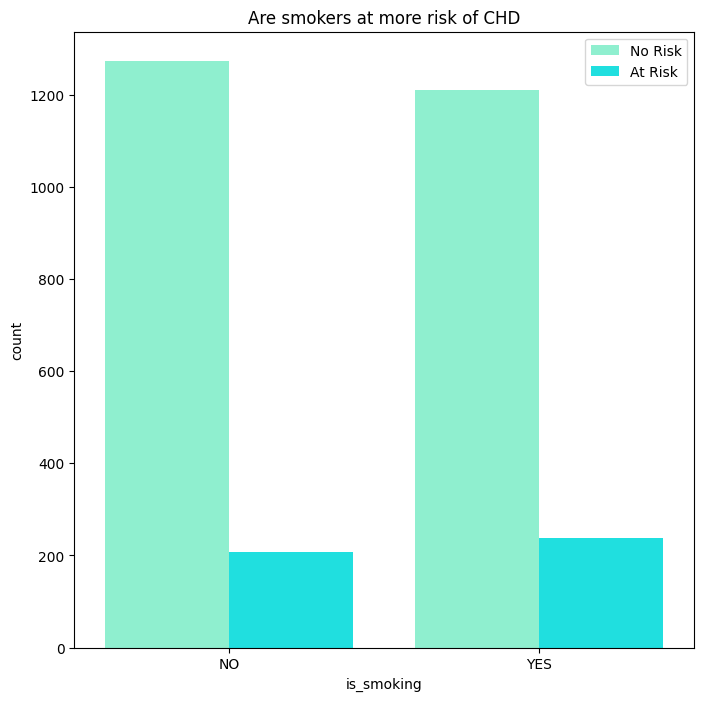

In [136]:
my_palette = {0 : 'aquamarine', 1 : 'aqua'}
plt.figure(figsize=(8,8))
sns.countplot(x = cvs_data['is_smoking'],hue = cvs_data['TenYearCHD'], palette = my_palette)
plt.title("Are smokers at more risk of CHD")
plt.legend(['No Risk','At Risk'])
plt.show()

Are hyper-tensive patients at more risk of coronary heart disease?

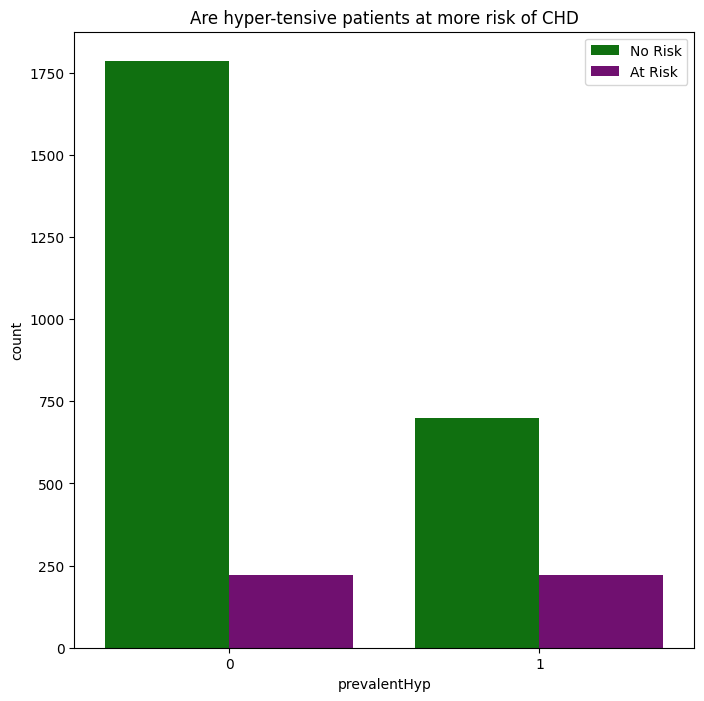

In [137]:
my_palette = {0 : 'green', 1 : 'purple'}
plt.figure(figsize=(8,8))
sns.countplot(x = cvs_data['prevalentHyp'],hue = cvs_data['TenYearCHD'], palette = my_palette)
plt.title("Are hyper-tensive patients at more risk of CHD")
plt.legend(['No Risk','At Risk'])
plt.show()

Are patients with blood pressure on medication at risk of coronary heart disease?

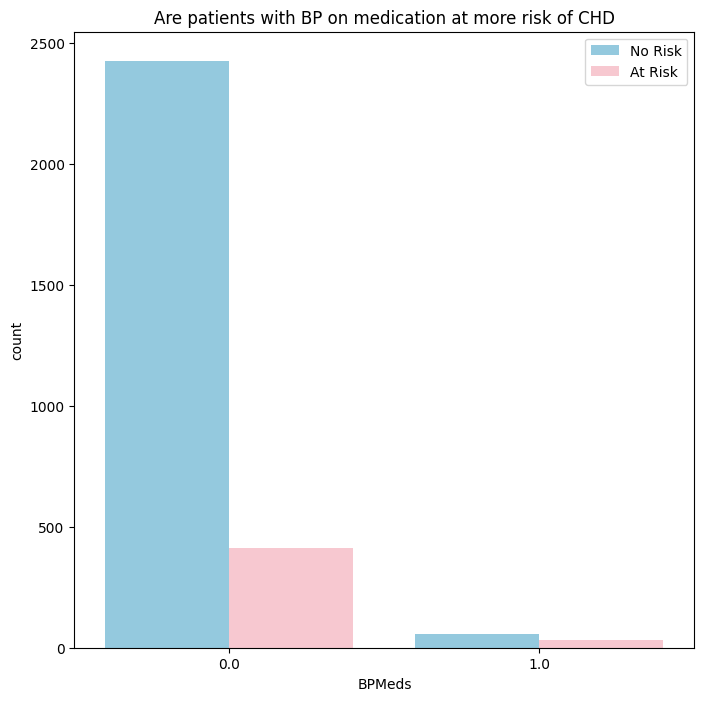

In [138]:
my_palette = {0 : 'skyblue', 1 : 'pink'}
plt.figure(figsize=(8,8))
sns.countplot(x = cvs_data['BPMeds'],hue = cvs_data['TenYearCHD'], palette = my_palette)
plt.title("Are patients with BP on medication at more risk of CHD")
plt.legend(['No Risk','At Risk'])
plt.show()

Which age group is more vulnerable to coronary heart disease?

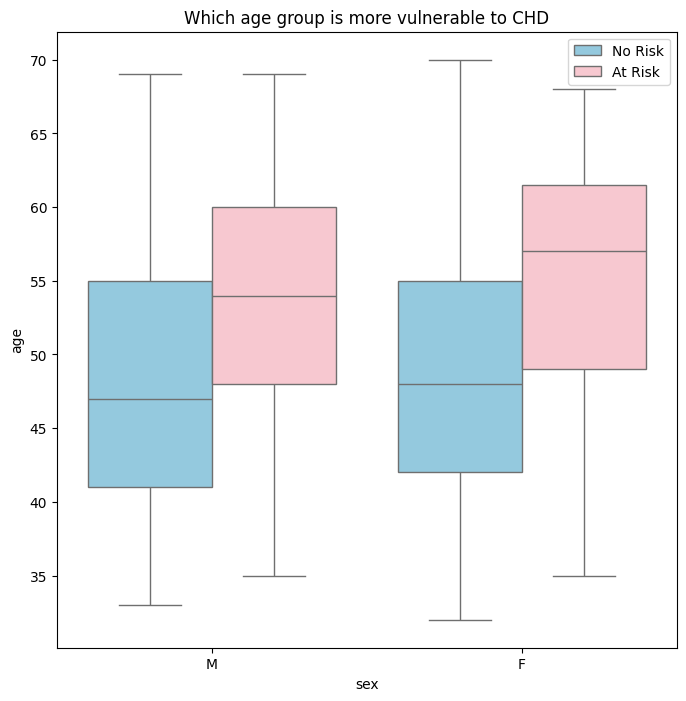

In [139]:
plt.figure(figsize=(8,8))
axis = sns.boxplot(x = cvs_data['sex'], y = cvs_data['age'], hue = cvs_data['TenYearCHD'], palette = my_palette)
plt.title("Which age group is more vulnerable to CHD")
handles, _ = axis.get_legend_handles_labels()
axis.legend(handles, ['No Risk','At Risk'], loc = "best")
plt.show()

Is heart rate responsible for coronary heart disease(CHD)?

In [140]:
def heartRate_data(row):
  if row['heartRate'] <= 59:
    value = 'Low'
  elif row['heartRate'] < 100:
    value = 'Normal'
  else:
    value = 'High'
  return value

In [141]:
cvs_data['heartRateLabel'] = cvs_data.apply(heartRate_data, axis = 1)

In [142]:
cvs_data['heartRateLabel'].value_counts()

,count
heartRateLabel,
Normal,2666
High,131
Low,130


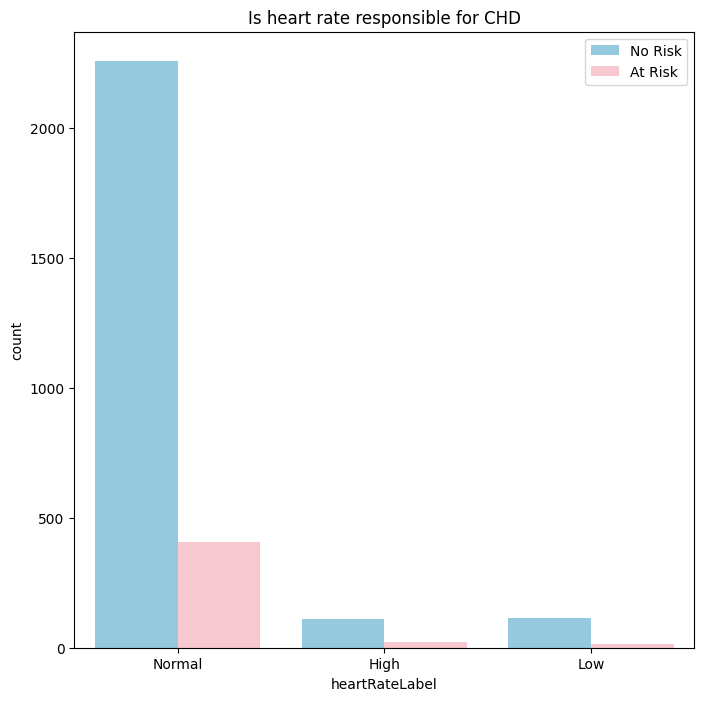

In [143]:
my_palette = {0 : 'skyblue', 1 : 'pink'}
plt.figure(figsize=(8,8))
sns.countplot(x = cvs_data['heartRateLabel'],hue = cvs_data['TenYearCHD'], palette = my_palette)
plt.title("Is heart rate responsible for CHD")
plt.legend(['No Risk','At Risk'])
plt.show()

In [144]:
cvs_data.drop(columns=['heartRateLabel'], inplace=True)

How much smoking affects coronary heart disease(CHD)?

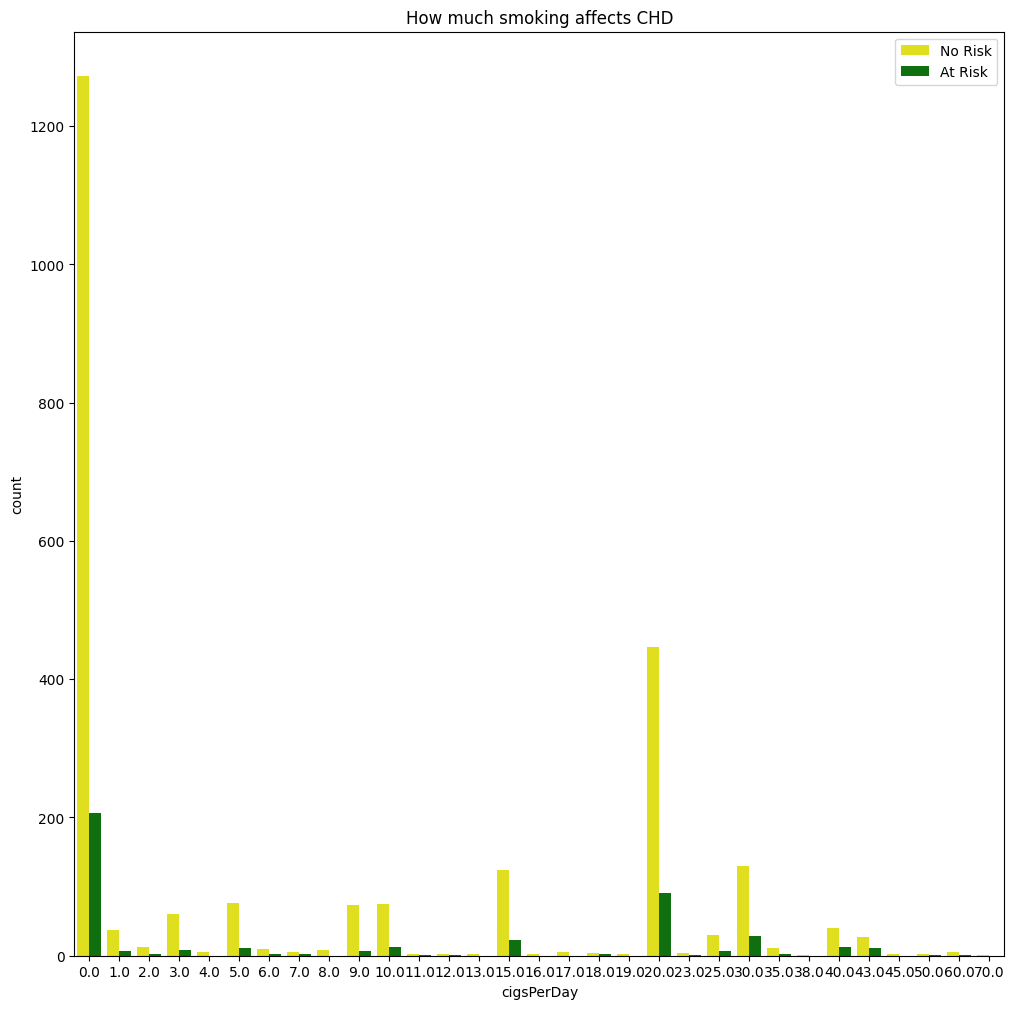

In [145]:
my_palette = {0 : 'yellow', 1 : 'green'}
plt.figure(figsize=(12,12))
sns.countplot(x = cvs_data['cigsPerDay'],hue = cvs_data['TenYearCHD'], palette = my_palette)
plt.title("How much smoking affects CHD")
plt.legend(['No Risk','At Risk'])
plt.show()

Whether a person who had a stroke earlier more prone to coronary heart disease(CHD)?

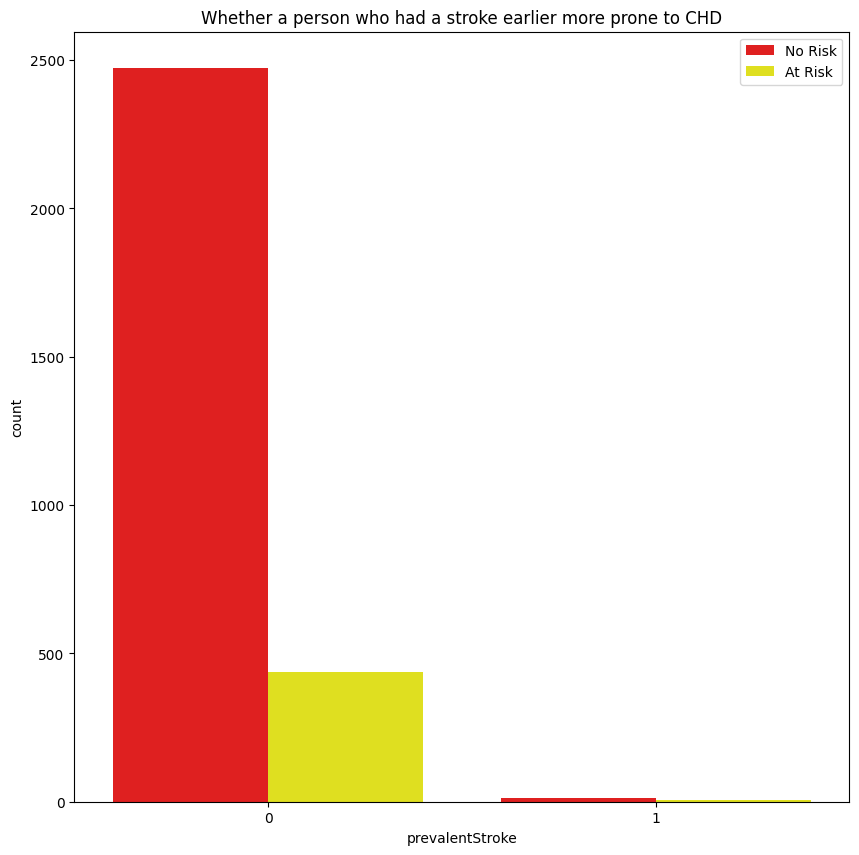

In [146]:
my_palette = {0 : 'red', 1 : 'yellow'}
# 10-year risk of coronary heart disese CHD(binary : "1", means "Yes", "0" means "No")
plt.figure(figsize=(10,10))
sns.countplot(x = cvs_data['prevalentStroke'],hue = cvs_data['TenYearCHD'], palette = my_palette)
plt.title("Whether a person who had a stroke earlier more prone to CHD")
plt.legend(['No Risk','At Risk'])
plt.show()

Are patients with systolic BP at risk of CHD?

Is patients BMI important to show the risk of CHD?

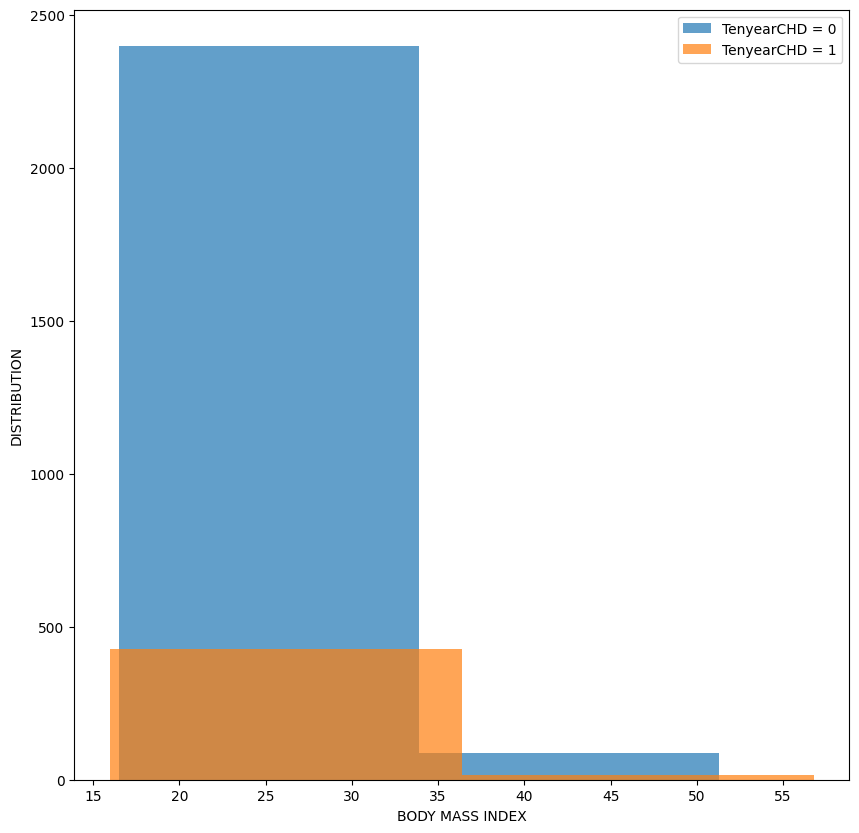

In [147]:
plt.figure(figsize=(10,10))

plt.hist(cvs_data['BMI'][cvs_data['TenYearCHD'] == 0], bins = 2, alpha = 0.7, label='TenyearCHD = 0')
plt.hist(cvs_data['BMI'][cvs_data['TenYearCHD'] == 1], bins = 2, alpha = 0.7, label='TenyearCHD = 1')
plt.ylabel('DISTRIBUTION')
plt.xlabel('BODY MASS INDEX')
plt.legend()

Can patients glucose levels show the risk of CHD?

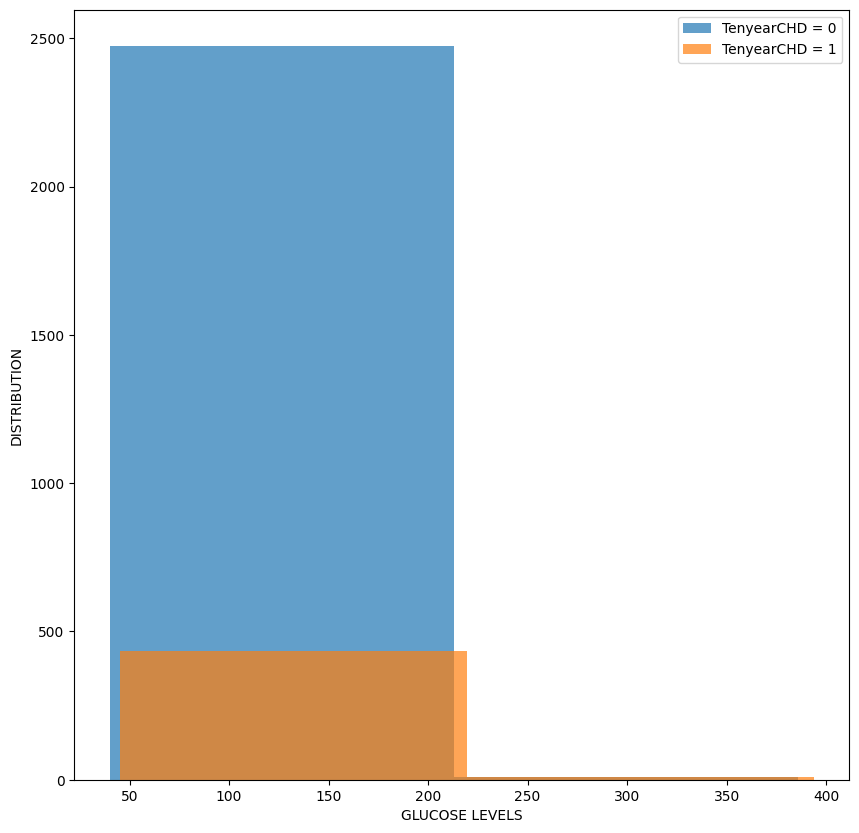

In [148]:
plt.figure(figsize=(10,10))

plt.hist(cvs_data['glucose'][cvs_data['TenYearCHD'] == 0], bins = 2, alpha = 0.7, label='TenyearCHD = 0')
plt.hist(cvs_data['glucose'][cvs_data['TenYearCHD'] == 1], bins = 2, alpha = 0.7, label='TenyearCHD = 1')
plt.ylabel('DISTRIBUTION')
plt.xlabel('GLUCOSE LEVELS')
plt.legend()

Systolic and diastolic blood pressure has a high correlation that can be commonly classified into hypertension.

In [149]:
def blood_pressure_classification(SysBP,diaBP):
  if (SysBP < 90) or (diaBP < 60):
    return 0 # 'Hypotension'
  if (SysBP < 120) or (diaBP < 80):
    return 1 # 'Optimal'
  if (SysBP < 130) or (diaBP < 86):
    return 2 # 'Normal'
  if (SysBP < 140) or (diaBP < 90):
    return 3 # 'PreHypertensive'
  if (SysBP > 140) or (diaBP < 90):
    return 4 # 'IsolatedSystolicHypertension'
  if (SysBP < 160) or (diaBP < 100):
    return 5 # 'GradeI'
  if (SysBP < 180) or (diaBP < 110):
    return 6 # 'GradeII'
  return 7 # 'GradeIII'

In [150]:
print(cvs_data.columns)

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')


In [151]:
cvs_data['Hypertension'] = cvs_data.apply(lambda x: blood_pressure_classification(x['sysBP'], x['diaBP']), axis=1)
cvs_data.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,Hypertension
id,,,,,,,,,,,,,,,,,
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,4
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,1
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,3
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,2
5,61,3.0,F,NO,0.0,0.0,0,1,0,272.0,182.0,121.0,32.80,85.0,65.0,1,4


Blood glucose levels can be used to classify the severity of diabetes

In [152]:
def diabetes_grade(glucose):
  if glucose < 100:
    return 1 # 'Normal'
  if glucose < 125:
    return 2 # 'Prediabetic'
  if glucose < 200:
    return 3 # 'Mild'
  if glucose < 400:
    return 4 # 'Moderate'
  return 5 # 'Severe'

In [153]:
cvs_data['Diabetes'] = cvs_data['glucose'].apply(lambda x: diabetes_grade(x))
cvs_data.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,Hypertension,Diabetes
id,,,,,,,,,,,,,,,,,,
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,4,1
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,1,1
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,3,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,2,1
5,61,3.0,F,NO,0.0,0.0,0,1,0,272.0,182.0,121.0,32.80,85.0,65.0,1,4,1


The absolute number of cigarettes per day is not much useful variable because the stiffness of blood vessels increases as the number of cigarettes consumed per day increases. So new feature containing log-transformed value could be more useful.

In [154]:
cvs_data['SmokingFactor'] = cvs_data['cigsPerDay'].apply(lambda x: 0 if x < 1 else np.log(x))
cvs_data.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,Hypertension,Diabetes,SmokingFactor
id,,,,,,,,,,,,,,,,,,,
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,4,1,0.000000
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,1,1,2.302585
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,3,1,2.995732
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,2,1,3.401197
5,61,3.0,F,NO,0.0,0.0,0,1,0,272.0,182.0,121.0,32.80,85.0,65.0,1,4,1,0.000000


In [155]:
# Remove unuseful columns
cvs_data.drop(columns=['prevalentHyp','sysBP','diaBP','glucose','diabetes','is_smoking','cigsPerDay'], inplace=True)

In [156]:
numerical_data = cvs_data.select_dtypes(include=[np.number])

<Axes: >

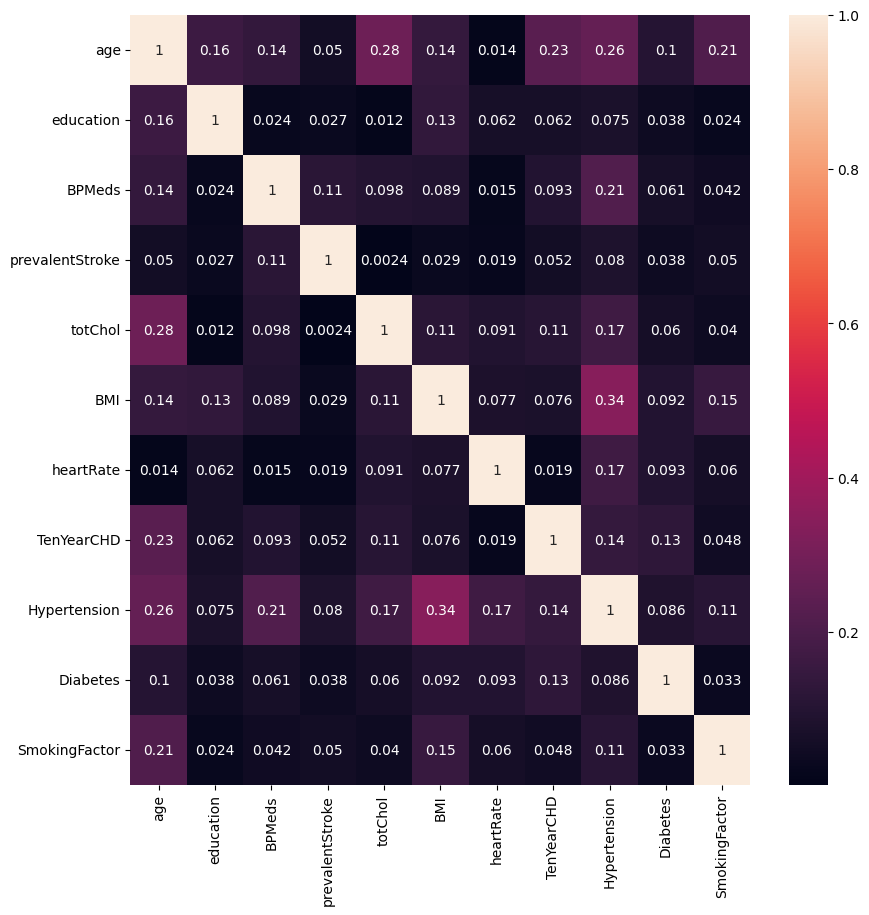

In [157]:
# Plotting the correlation matrix using heatmap
plt.figure(figsize=(10,10))
correlation = numerical_data.corr()
sns.heatmap(abs(correlation), annot=True)

<function matplotlib.pyplot.show(close=None, block=None)>

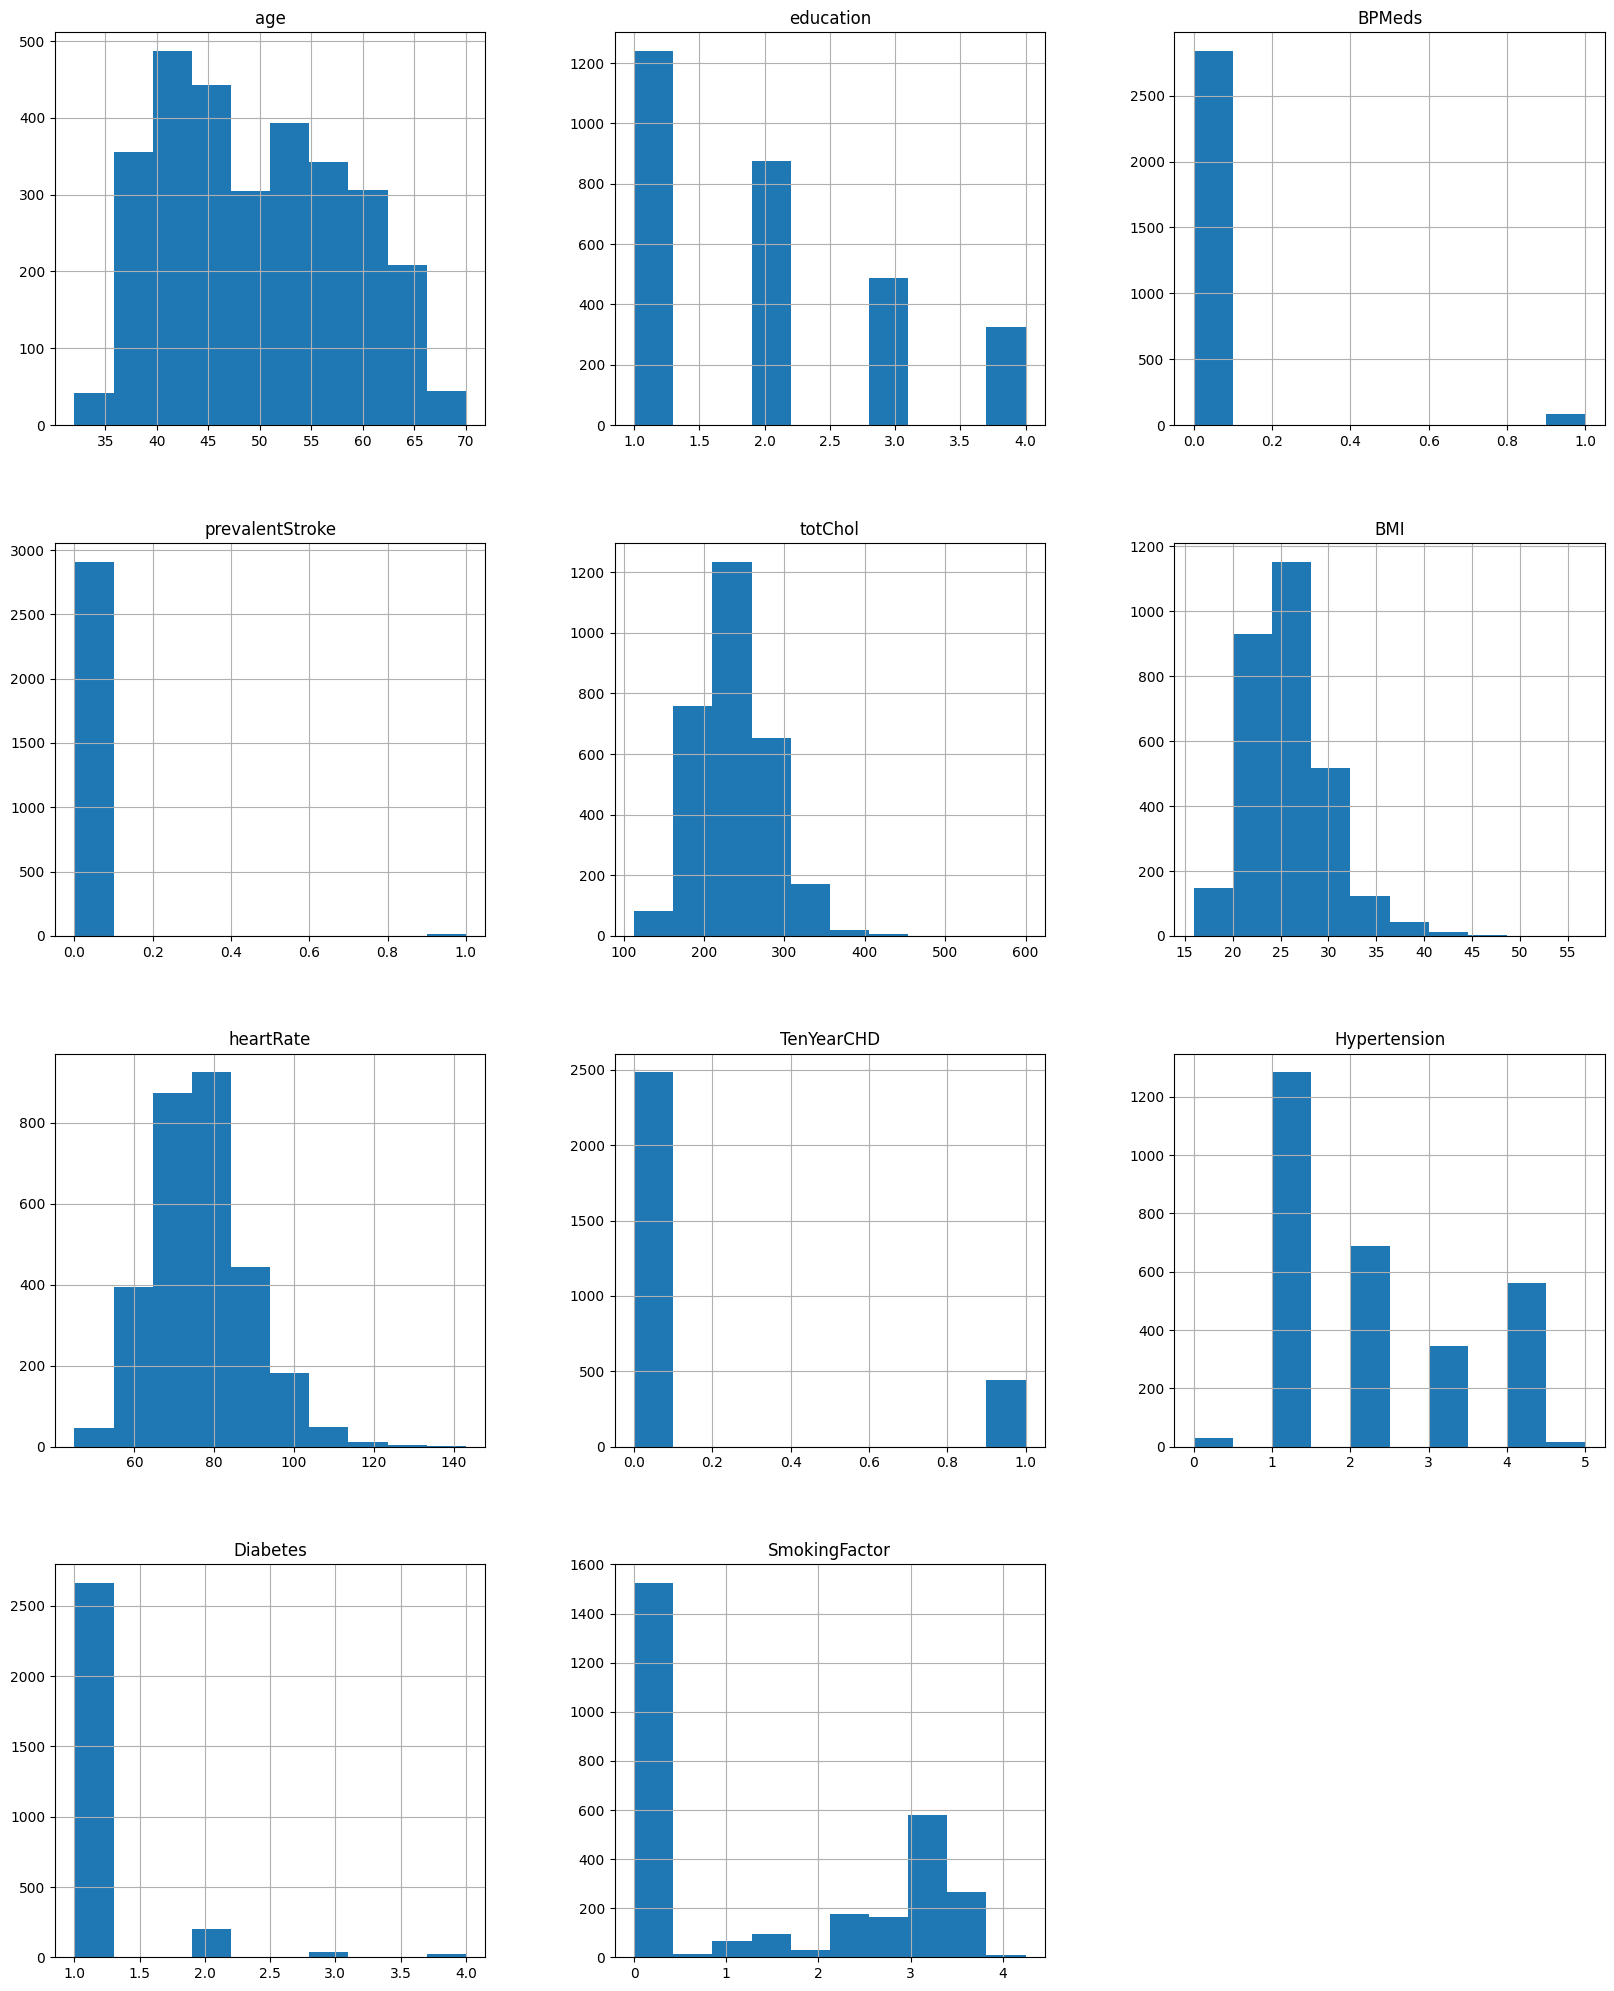

In [158]:
# Plot the histogram to see the distribution of the data
fig = plt.figure(figsize=(20,25))
ax = fig.gca()
cvs_data.hist(ax = ax)
plt.show

BPMeds and prevalentStroke are not useful in explaining variance so we can remove those columns.

In [159]:
# Remove unuseful columns
cvs_data.drop(columns=['BPMeds', 'prevalentStroke'], inplace=True)

In [160]:
cvs_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2927 entries, 1 to 3389
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            2927 non-null   int64  
 1   education      2927 non-null   float64
 2   sex            2927 non-null   object 
 3   totChol        2927 non-null   float64
 4   BMI            2927 non-null   float64
 5   heartRate      2927 non-null   float64
 6   TenYearCHD     2927 non-null   int64  
 7   Hypertension   2927 non-null   int64  
 8   Diabetes       2927 non-null   int64  
 9   SmokingFactor  2927 non-null   float64
dtypes: float64(5), int64(4), object(1)
memory usage: 251.5+ KB


Converting categorical data into numerical data for model training

In [161]:
cvs_data['sex'] = cvs_data['sex'].apply(lambda x: 1 if x == 'M' else 0)

In [162]:
cvs_data.head()

,age,education,sex,totChol,BMI,heartRate,TenYearCHD,Hypertension,Diabetes,SmokingFactor
id,,,,,,,,,,
1,36,4.0,1,212.0,29.77,72.0,0,4,1,0.000000
2,46,1.0,0,250.0,20.35,88.0,0,1,1,2.302585
3,50,1.0,1,233.0,28.26,68.0,1,3,1,2.995732
4,64,1.0,0,241.0,26.42,70.0,0,2,1,3.401197
5,61,3.0,0,272.0,32.80,85.0,1,4,1,0.000000


In [163]:
dependent_var = 'TenYearCHD'
independent_var = list(cvs_data.columns)
independent_var.remove(dependent_var)
print(independent_var)

['age', 'education', 'sex', 'totChol', 'BMI', 'heartRate', 'Hypertension', 'Diabetes', 'SmokingFactor']


In [164]:
X = cvs_data[independent_var].values
y = cvs_data[dependent_var].values

Let's resample the dataset to overcome this imbalance. We will apply SMOTE(Synthetic Minority Oversampling Technique) to resample the data. It works by randomly picking a point from the minority class and computing the k-nearest neighbours for this point. The synthetic points are added between the chosen point and it's neighbours.

In [168]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y)
print('Before',counter)

# Oversampling the train dataset using SMOTE
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X, y)

counter  = Counter(y_train_sm)
print('After',counter)

Before Counter({np.int64(0): 2483, np.int64(1): 444})
After Counter({np.int64(0): 2483, np.int64(1): 2483})


In [169]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(X_train_sm, y_train_sm,test_size=.2)

In [170]:
# Now train and build the model using XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [171]:
train_prediction = xgb_model.predict(X_train)
test_prediction = xgb_model.predict(X_test)

In [172]:
testing_acc = accuracy_score(y_test, test_prediction) * 100
print(f"The Testing Accuracy is {testing_acc}")

training_acc = accuracy_score(y_train, train_prediction) * 100
print(f"The Training Accuracy is {training_acc}")

The Testing Accuracy is 88.93360160965796
The Training Accuracy is 99.49647532729104


[[1979    0]
 [  20 1973]]


[Text(0, 0.5, 'No Risk'), Text(0, 1.5, 'At Risk')]

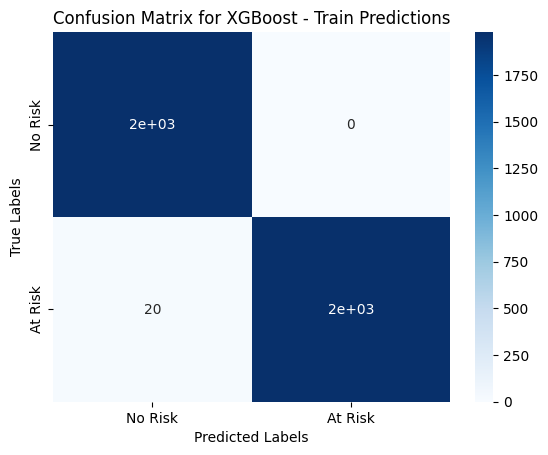

In [173]:
labels = ['No Risk', 'At Risk']
cm = confusion_matrix(y_train, train_prediction)
print(cm)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues')  # optional: add color map

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for XGBoost - Train Predictions')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

[[466  38]
 [ 72 418]]


[Text(0, 0.5, 'No Risk'), Text(0, 1.5, 'At Risk')]

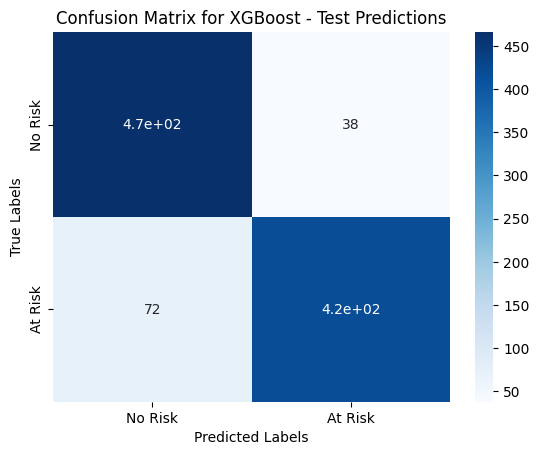

In [174]:
labels = ['No Risk', 'At Risk']
cm = confusion_matrix(y_test, test_prediction)
print(cm)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues')  # Optional: Add color map

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for XGBoost - Test Predictions')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)


In [175]:
# Classification report for train data
print(classification_report(y_train, train_prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1979
           1       1.00      0.99      0.99      1993

    accuracy                           0.99      3972
   macro avg       0.99      0.99      0.99      3972
weighted avg       1.00      0.99      0.99      3972



In [176]:
# Classification report for test data
print(classification_report(y_test, test_prediction))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       504
           1       0.92      0.85      0.88       490

    accuracy                           0.89       994
   macro avg       0.89      0.89      0.89       994
weighted avg       0.89      0.89      0.89       994

